In [7]:
!pip install --quiet yfinance pandas matplotlib scikit-learn statsmodels prophet tensorflow==2.16.1 numpy==1.26.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 891.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.16.1 which is incompatible.
tensorstore 0.1.76 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.16.1 which is incompatible.
orbax-checkpoint 0.11.20 requires jax>=0.5.0, but you have jax 0.4.30 which is 

In [8]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# For ARIMA (statsmodels only, no pmdarima)
from statsmodels.tsa.arima.model import ARIMA

# For Prophet
from prophet import Prophet

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Utility: evaluation
import math

In [9]:
def eval_metrics(true, pred):
    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- Helper: simple auto-arima using statsmodels grid search (small ranges for speed) ---
def auto_arima_grid(series, p_max=3, d_max=2, q_max=3):
    """Brute-force search over (p,d,q) using AIC. Returns best_order and fitted model.
    Keep ranges small to keep runtime short."""
    best_aic = np.inf
    best_order = None
    best_model = None
    # Limit total fits for speed: break early if too many failures
    for d in range(0, d_max+1):
        for p in range(0, p_max+1):
            for q in range(0, q_max+1):
                try:
                    # suppress output and fit quietly
                    model = ARIMA(series, order=(p,d,q)).fit()
                    aic = model.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p,d,q)
                        best_model = model
                except Exception:
                    continue
    if best_order is None:
        raise RuntimeError('No ARIMA model converged. Try expanding search or check data.')
    return best_order, best_model

In [11]:
CSV_CANDIDATES = ['NFLX.csv', 'netflix.csv', 'Netflix.csv']
loaded = False
for fname in CSV_CANDIDATES:
    if os.path.exists(fname):
        df = pd.read_csv(fname)
        loaded = True
        print(f'Loaded local file: {fname}')
        break
if not loaded:
    print('No local CSV found. Downloading from yfinance (ticker NFLX)...')
    df = yf.download('NFLX', start='2002-02-20', end=pd.Timestamp.today().strftime('%Y-%m-%d'))
    df.reset_index(inplace=True)

Loaded local file: NFLX.csv


Data range: 2002-05-23 to 2022-06-03
Using subset for speed: 2019-06-03 to 2022-06-03


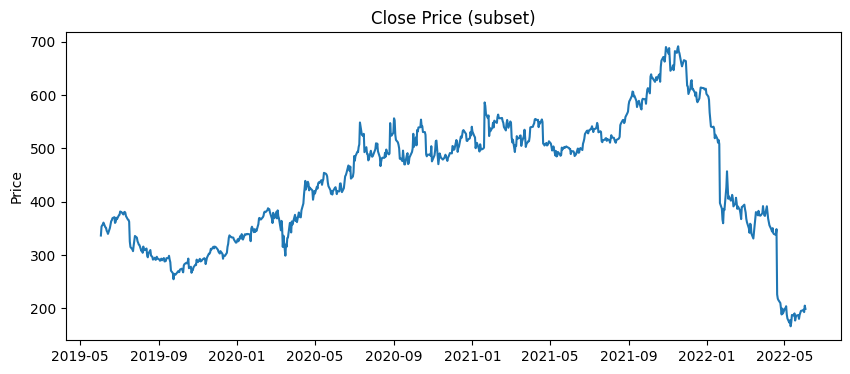

In [12]:
# Keep Date and Close (adjusted close if available)
if 'Date' not in df.columns and 'date' in df.columns:
    df.rename(columns={'date':'Date'}, inplace=True)

if 'Adj Close' in df.columns:
    price_col = 'Adj Close'
elif 'Adj_Close' in df.columns:
    price_col = 'Adj_Close'
elif 'Close' in df.columns:
    price_col = 'Close'
else:
    raise ValueError('No Close/Adj Close column found')

data = df[['Date', price_col]].copy()
data.columns = ['Date', 'Close']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

data = data.asfreq('B')  # business day frequency
data['Close'].interpolate(inplace=True)  # fill missing days

print('Data range:', data.index.min().date(), 'to', data.index.max().date())

# We'll use last 3 years for speed by default; full-data option available by changing years_to_use
years_to_use = 3
start_cutoff = data.index.max() - pd.DateOffset(years=years_to_use)
data_short = data.loc[start_cutoff:]
print('Using subset for speed:', data_short.index.min().date(), 'to', data_short.index.max().date())

# Train-test split: last 60 business days as test
test_days = 60
train = data_short.iloc[:-test_days]
test = data_short.iloc[-test_days:]

# Plot
plt.figure(figsize=(10,4))
plt.plot(data_short.index, data_short['Close'])
plt.title('Close Price (subset)')
plt.ylabel('Price')
plt.show()


=== ARIMA (statsmodels grid search) ===
Selected ARIMA order: (2, 1, 2)
ARIMA metrics: {'RMSE': 112.80831944608177, 'MAE': 92.76202632353059, 'R2': -0.692671140601824}


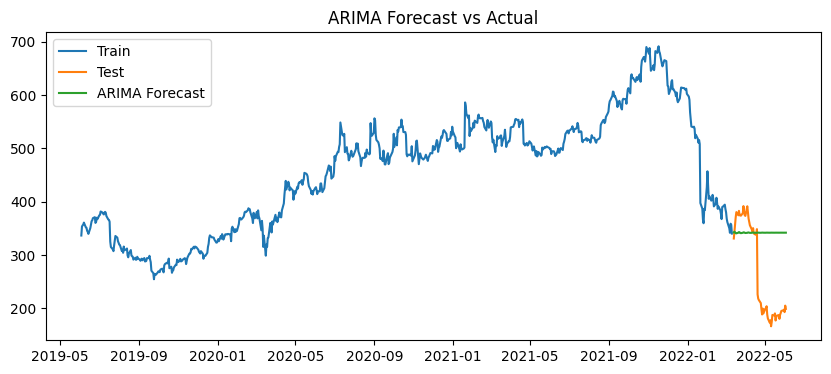

In [14]:

print('=== ARIMA (statsmodels grid search) ===')
# Use a small grid for speed
best_order, best_model = auto_arima_grid(train['Close'], p_max=3, d_max=2, q_max=3)
print('Selected ARIMA order:', best_order)

# Forecast
forecast_arima = best_model.forecast(steps=test_days)
metrics_arima = eval_metrics(test['Close'].values, forecast_arima.values)
print('ARIMA metrics:', metrics_arima)

plt.figure(figsize=(10,4))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()


=== Prophet ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmp56h_e45u/0bx743e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp56h_e45u/isyqldb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93485', 'data', 'file=/tmp/tmp56h_e45u/0bx743e1.json', 'init=/tmp/tmp56h_e45u/isyqldb1.json', 'output', 'file=/tmp/tmp56h_e45u/prophet_modelz_b2odbd/prophet_model-20250812144054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet metrics: {'RMSE': 55.86336944455135, 'MAE': 50.99112791967867, 'R2': 0.5849077882975687}


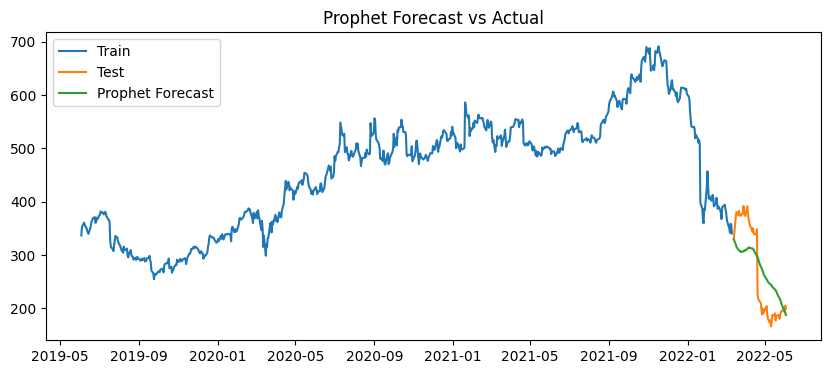

In [15]:
print('=== Prophet ===')
prophet_df = train.reset_index().rename(columns={'Date':'ds','Close':'y'})[['ds','y']]
model_prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=test_days, freq='B')
forecast = model_prophet.predict(future)
prophet_pred = forecast.set_index('ds')['yhat'].loc[test.index]
metrics_prophet = eval_metrics(test['Close'].values, prophet_pred.values)
print('Prophet metrics:', metrics_prophet)

plt.figure(figsize=(10,4))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, prophet_pred, label='Prophet Forecast')
plt.legend()
plt.title('Prophet Forecast vs Actual')
plt.show()

=== LSTM ===
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0789 - val_loss: 0.0076
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0058 - val_loss: 0.0081
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0072
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
LSTM metrics (on overlapping test dates): {'RMSE': 44.37707732482231, 'MAE': 32.19216408806966, 'R2': 0.7380564413822228}


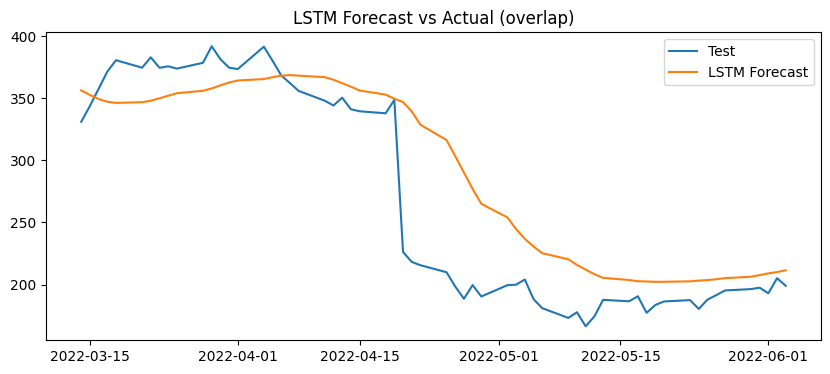

In [17]:
print('=== LSTM ===')
# Use full data_short for LSTM (train on same split)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_short[['Close']])

# build sequences
def make_sequences(arr, window):
    X, y = [], []
    for i in range(window, len(arr)):
        X.append(arr[i-window:i, 0])
        y.append(arr[i, 0])
    return np.array(X), np.array(y)

window = 30  # 30 days window — small for speed
X_all, y_all = make_sequences(scaled, window)

# Map indices to dates: sequences start at index = window
dates_all = data_short.index[window:]

# determine train/test split based on dates
split_date = test.index[0]
train_idx = dates_all < split_date
X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_test = X_all[~train_idx]
y_test = y_all[~train_idx]

# reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[es], verbose=1)

# Predict: note X_test corresponds from window onwards; align predictions with test index
pred_scaled = model.predict(X_test).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

# The first X_test corresponds to date = dates_all[train_count]
pred_dates = dates_all[~train_idx]

# Align with true test values: our test set earlier had length test_days; LSTM predictions will match that if window and splitting were consistent.
# We'll take predictions for dates present in test.index intersection
common_dates = np.intersect1d(test.index, pred_dates)
pred_for_test = []
true_for_test = []
for d in common_dates:
    idx = list(pred_dates).index(pd.to_datetime(d))
    pred_for_test.append(pred[idx])
    true_for_test.append(data_short.loc[d,'Close'])

metrics_lstm = eval_metrics(np.array(true_for_test), np.array(pred_for_test))
print('LSTM metrics (on overlapping test dates):', metrics_lstm)

plt.figure(figsize=(10,4))
plt.plot(test.index, test['Close'], label='Test')
plt.plot(common_dates, pred_for_test, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Forecast vs Actual (overlap)')
plt.show()


In [19]:
results = pd.DataFrame([
    {'Model':'ARIMA','RMSE':metrics_arima['RMSE'],'MAE':metrics_arima['MAE'],'R2':metrics_arima['R2']},
    {'Model':'Prophet','RMSE':metrics_prophet['RMSE'],'MAE':metrics_prophet['MAE'],'R2':metrics_prophet['R2']},
    {'Model':'LSTM','RMSE':metrics_lstm['RMSE'],'MAE':metrics_lstm['MAE'],'R2':metrics_lstm['R2']}
])

print('Model comparison (lower RMSE/MAE better, higher R2 better):')
display(results)

# End: Save forecasts to CSV
out = pd.DataFrame({'date': test.index, 'actual': test['Close'].values, 'arima': forecast_arima.values, 'prophet': prophet_pred.values})
out.set_index('date', inplace=True)
out.to_csv('forecast_comparison.csv')
print('Saved forecast_comparison.csv')


Model comparison (lower RMSE/MAE better, higher R2 better):


,Model,RMSE,MAE,R2
0,ARIMA,112.808319,92.762026,-0.692671
1,Prophet,55.863369,50.991128,0.584908
2,LSTM,44.377077,32.192164,0.738056


Saved forecast_comparison.csv
